## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [1]:
import numpy as np
import pandas as pd

import os

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Read the Data

In [2]:
# List files available
print(os.listdir('../input/'))

['home-credit-default-risk']


In [3]:
# Training data
train_df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', train_df.shape)
train_df.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 columns including the `TARGET` (the label we want to predict).

In [4]:
# Testing data features
test_df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', test_df.shape)
test_df.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test set is considerably smaller and lacks a `TARGET` column.

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas of the data. The findings may be interesting in their own right, or they may be used to inform our modeling choices, such as by helping us decide which features to use.

### Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loands falling into each category.

In [5]:
train_df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [6]:
train_df['TARGET'].value_counts(normalize=True) * 100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

### Examine Missing Values

Next we can look at the number and percentage of missing values in each column.

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(train_df)
missing_values.head(20).style.background_gradient(cmap='Reds')

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.900000
COMMONAREA_AVG,214865,69.900000
COMMONAREA_MODE,214865,69.900000
NONLIVINGAPARTMENTS_MEDI,213514,69.400000
NONLIVINGAPARTMENTS_MODE,213514,69.400000
NONLIVINGAPARTMENTS_AVG,213514,69.400000
FONDKAPREMONT_MODE,210295,68.400000
LIVINGAPARTMENTS_MODE,210199,68.400000
LIVINGAPARTMENTS_MEDI,210199,68.400000
LIVINGAPARTMENTS_AVG,210199,68.400000


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [9]:
# Number of each type of column
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Now let's look at the number of unique entries in each of the `object` (categorical) columns.

In [10]:
# Number of unique classes in each object column
train_df.select_dtypes(include=['object']).apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](https://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label Encoding: Assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below:
![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: Create a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category and a 0 in all other new columns.
![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer receives a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want, If we only have two unique values for a categorical variable (such as Male/Female), the label encoding is fine, but for more than 2 unique categories, one-hot encoding is a safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good StackOverflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classe, one-hot encoding is the safest option because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categoires. To deal with this, we can perform one-hot-encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve the information).

In this notebook, we will use Label Encoding for categorical variables with only 2 categories and one-hot encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but we will explore that in future iterations).

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any catgorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [11]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate thorugh the columns
for feature in train_df:
    if train_df[feature].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_df[feature].unique())) <= 2:
            # Train on the training data
            le.fit(train_df[feature])
            # Transform both training and testing data
            train_df[feature] = le.transform(train_df[feature])
            test_df[feature] = le.transform(test_df[feature])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print(f'{le_count} columns were label encoded.')

3 columns were label encoded.


In [12]:
# one-hot encoding of categorical variables
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

print(f'Training features shape: {train_df.shape}')
print(f'Testing features shape: {test_df.shape}')

Training features shape: (307511, 243)
Testing features shape: (48744, 239)


### Aligning Training and Testing Data
    
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created in the training data because there were some categirical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the alignment, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [13]:
train_labels = train_df['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train_df, test_df = train_df.align(test_df, join='inner', axis=1)

# Add the target back in
train_df['TARGET'] = train_labels

print('Training features shape: ', train_df.shape)
print('Testing features shape: ', test_df.shape)

Training features shape:  (307511, 240)
Testing features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduct the size of the datasets.

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` coluumn are negative because they are recorded relative to the current loan application. To see these stats in years, we can multiple by -1 and divide by the number of days in a year.

In [14]:
(train_df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [15]:
train_df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look rigt! The maximum value (besides being positive) is about 1000 years!

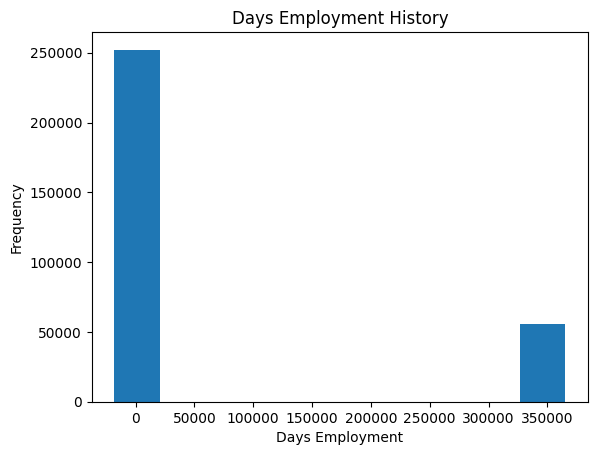

In [16]:
train_df['DAYS_EMPLOYED'].plot.hist(title='Days Employment History')
plt.xlabel('Days Employment');

Just out of curiosity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [17]:
anom = train_df[train_df['DAYS_EMPLOYED'] == 365243]
non_anom = train_df[train_df['DAYS_EMPLOYED'] != 365243]

print(f'The non-anomalies default on {non_anom["TARGET"].mean() * 100:.2f}% of loans.')
print(f'The anomalies default on {anom["TARGET"].mean() * 100:.2f}% of loans.' )
print(f'There are {len(anom)} anomalous days of employment.')

The non-anomalies default on 8.66% of loans.
The anomalies default on 5.40% of loans.
There are 55374 anomalous days of employment.


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Hnadling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using imputation) before machine learning. In this case, since all the anomalies have the exast same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we fill in the anomalous values with not a number (`np.nan`) and then create a new boolnea column indicating whether or not the value was anomalous.

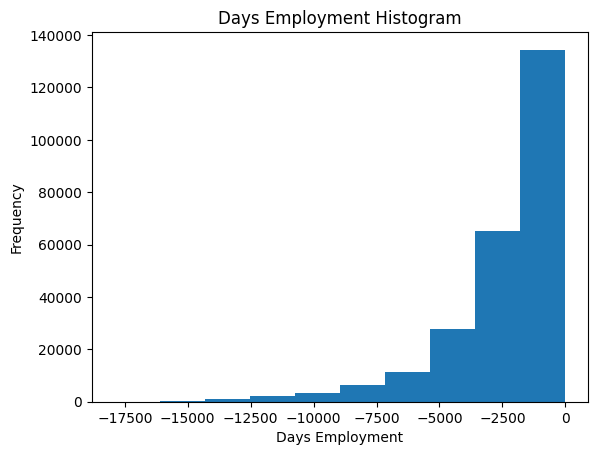

In [18]:
# Create an anomalous flag column
train_df['DAYS_EMPLOYED_ANOM'] = train_df['DAYS_EMPLOYED'] == 365243

# Replace the anomalous values with nan
train_df['DAYS_EMPLOYED'] = train_df['DAYS_EMPLOYED'].replace({365243: np.nan})

train_df['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment');

The distribution looks much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anmalous (because we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data, we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data.

In [19]:
test_df['DAYS_EMPLOYED_ANOM'] = test_df['DAYS_EMPLOYED'] == 365243
test_df['DAYS_EMPLOYED'] = test_df['DAYS_EMPLOYED'].replace({365243: np.nan})

print(f"There are {test_df['DAYS_EMPLOYED_ANOM'].sum()} anomalies in the test data out of {len(test_df)} entries.")

There are 9274 anomalies in the test data out of 48744 entries.


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent the "relevance", but it does gives us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficient]() are:
* 0.00 - 0.19 : "very weak"
* 0.20 - 0.39 : "weak"
* 0.40 - 0.59 : "moderate"
* 0.60 - 0.79 : "strong"
* 0.80 - 1.00 : "very strong"

In [20]:
# Find correlations with the target and sort
correlations = train_df.corr()['TARGET'].sort_values()

# Display correlations:
print('Most positive correlations:\n', correlations.head(15))
print('\nMost negative correlations:\n', correlations.head(15))

Most positive correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
Name: TARGET, dtype: float64

Most negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher edu

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlatio (except for `TARGET` because the correlation of a variable with itself is always 1). 

Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!).

The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, thery are less likely to default on their loan(i.e., `TARGET == 0`). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

## Effect of Age on Repayment

In [21]:
# Find the correlation of the positive day since birth and target
train_df['DAYS_BIRTH'] = abs(train_df['DAYS_BIRTH'])
train_df['DAYS_BIRTH'].corr(train_df['TARGET'])

-0.07823930830982694

As the clients get older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x-axis in years to make the plot a little more understandable.

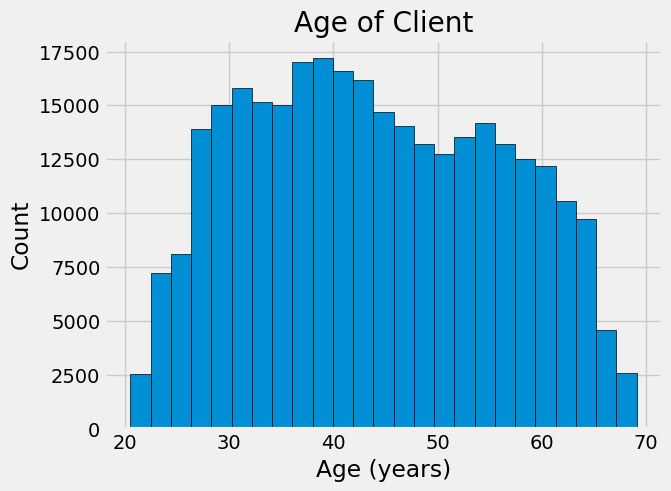

In [22]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train_df['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no otuliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot]() (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable]() and can be thought of as a smoothed histogram (it is created by computing a kernell, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn's `kdeplot` for this graph.

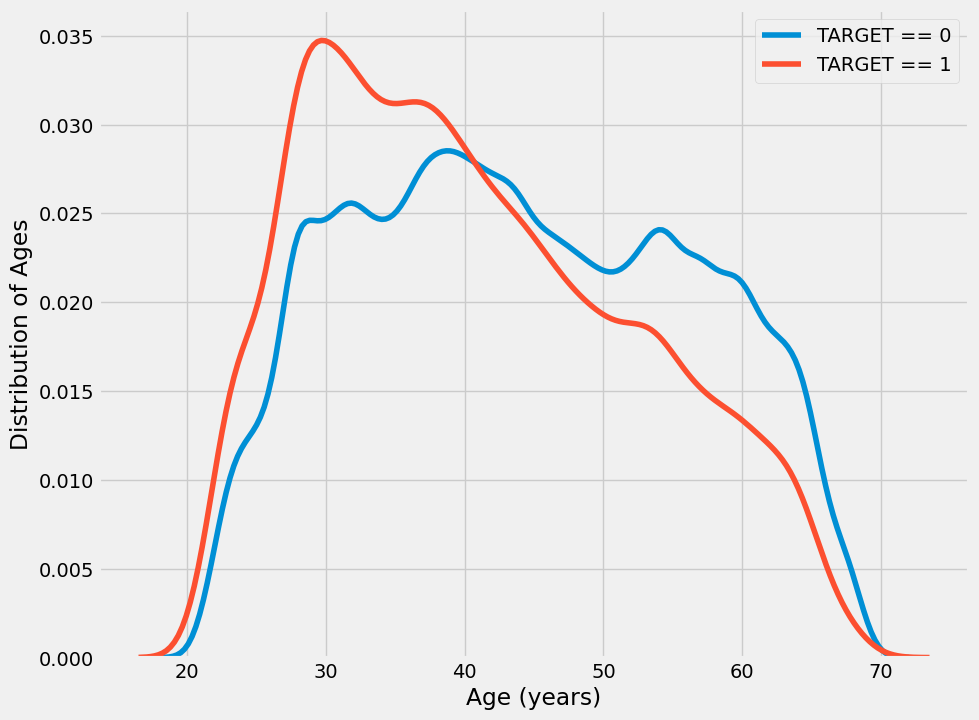

In [28]:
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='TARGET == 0')

# KDE plot of loans that were not repaid on time
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='TARGET == 1')

plt.xlabel('Age (years)')
plt.ylabel('Distribution of Ages')
plt.legend();

The `TARGET == 1` curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loands by age bracket.

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [38]:
# Store age information into a separate dataframe
age_data = train_df[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],
                                  bins=np.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [36]:
# np.linspace(20, 70, num=11)

In [35]:
# age_data['YEARS_BIRTH'].max(), age_data['YEARS_BIRTH'].min()

In [40]:
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


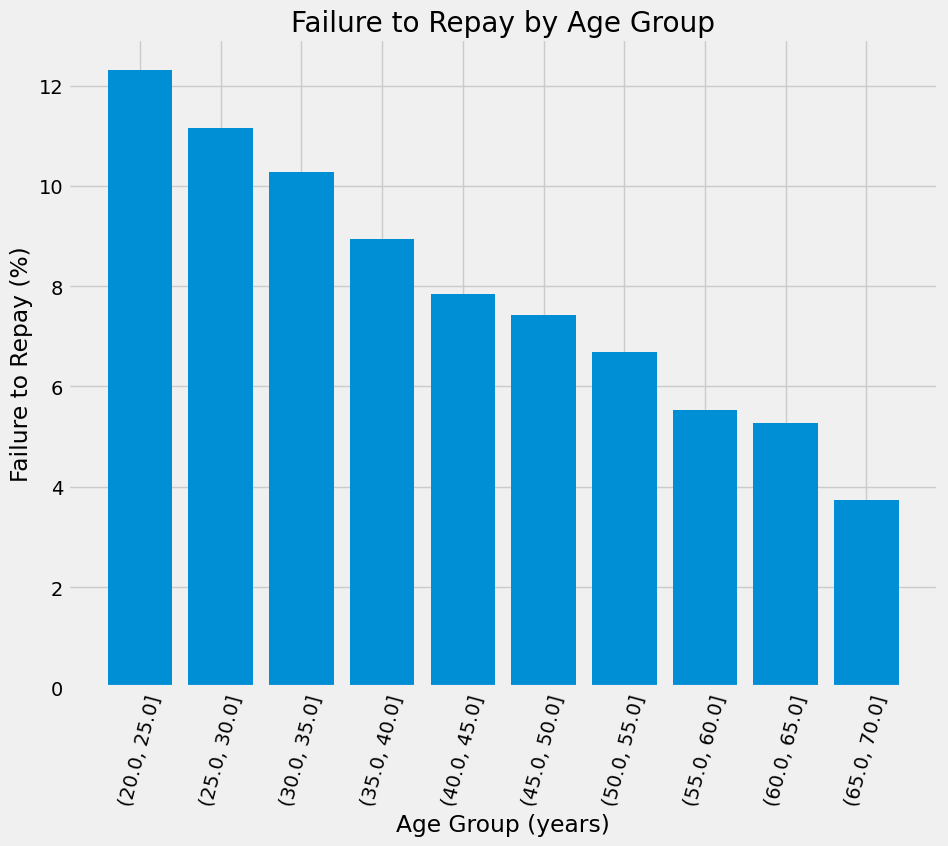

In [45]:
plt.figure(figsize=(10, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

We can see a clear trend: younger applicants are more likely to not repay the loan! The rate of failure is above 10% for the youngest three groups and below 5% for the oldest age group.
    
 This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measure to help younger clients pay on time.